<a href="https://colab.research.google.com/github/r6chow/IDC_Histopathology/blob/master/IDC_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install keras --upgrade
# ! pip install tensorflow --upgrade
!pip install annoy
#!pip install imbalanced-learn --upgrade

     |████████████████████████████████| 645kB 6.2MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297345 sha256=ea77c9a889508040b160d41b59d65278056f1902f809f5e75546e49676edfc8c
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


# Import libraries

In [2]:
import os
from google.colab import drive
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, models, optimizers, regularizers
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.preprocessing.image import ImageDataGenerator




import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors

from annoy import AnnoyIndex #approximate nearest neighbour

import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter

import itertools

import time
import datetime


import imblearn


#from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14067829342029468746
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9177843997146616237
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14116407328368082321
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7430351551743041677
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Functions

## Pad
This function will pad array with specified value to get the desired shape

In [0]:
def pad(array, shape, pad_value):
    """
    array: Array to be padded
    reference: Reference array with the desired shape
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    """
    # reference 
    result = np.full(shape, pad_value)
    # Create a list of slices from offset to offset + shape in each dimension
    
    if array.shape == result.shape:
      result = array
    else:
      insertHere = [slice(0, array.shape[dim]) for dim in range(array.ndim)]
      
      # Insert the array in the result at the specified offsets
      result[insertHere] = array
    
    return np.asarray(result)

## Show split
Show the distribution of data in Train, Validation and Test


In [0]:
def show_split(y_train, y_valid, y_test):

  total_rec = len(y_train) + len(y_valid) + len(y_test)
  print('Total count: {0}\n'.format(total_rec))
  #distribution of positive/negative cases in training, validation and test
  for tup in [('train', y_train), ('valid', y_valid), ('test',y_test)]:
      type_data =  tup[0]
      y_data = tup[1]

      num_rec = len(y_data)
      num_cancer = len([y for y in y_data if y[0] == 0])
      num_non_cancer = len([y for y in y_data if y[0] == 1])
      
      
      perc_rec = num_rec/total_rec
      
      perc_cancer = 0
      perc_non_cancer = 0
    
      if (num_rec > 0):
        perc_cancer =  num_cancer/num_rec
        perc_non_cancer = num_non_cancer/num_rec


      print('{0} count: {1} ({2:.5f})'.format(type_data, num_rec, perc_rec) )
      print('{0} cancer count: {1} ({2:.5f})'.format(type_data, num_cancer, perc_cancer))
      print('{0} non-cancer count: {1} ({2:.5f})\n'.format(type_data, num_non_cancer, perc_non_cancer) )
  

## Randomize pair of array


In [0]:
def randomize(a, b):

  indices = np.arange(len(a))
  np.random.seed(1)
  np.random.shuffle(indices)

  a = [a[idx] for idx in indices]
  b = [b[idx] for idx in indices]

  return a, b

## Custom batch generator

In [0]:
# reference:
# https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-2-be9ad08f3f0e

def image_label_generator(images, labels, batch_size=32, scale_factor=1, pad_flg=True, pad_size=(32,32,3), pad_value=255, image_data_generator = None):
    """
    Yields the next training batch.
    images is array of <pil Image>]
    labels is array of label.
    batch_size is the size of a batch
    scale is the scale to resize the image 
    """
    
    num_images = len(images)
    while True: # Loop forever so the generator never terminates
        
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_images, batch_size):
            #print('num_images:', num_images)
            
            #print('offset:', offset)
            # Get the images in batch
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            # Initialise X_batch and y_batch arrays for this batch
            X_batch = []
            y_batch = []

            # For each image in the batcn
            for i,batch_image in enumerate(batch_images):
                
                #print(batch_image)
                img = batch_image

                #print(batch_image['file'])
                #scale images
                newWidth = max(1, (int(img.size[0] * scale_factor)))
                newHeight = max(1, (int(img.size[1] * scale_factor)))
                img = img.resize( (newWidth, newHeight) )

                # #gaussain blur  
                # rnd = np.random.random()
                # if rnd > 0.5:
                #   img = img.filter(ImageFilter.GaussianBlur)

                # #convert to RGB and standardize images to size pad_size (ie. (32,32,3) )
                # rgb_img = np.asarray(img)

                if pad_flg:
                  rgb_img = pad(np.asarray(img), pad_size, pad_value)

                # apply random image augmentation
                if (image_data_generator != None):
                  params = image_data_generator.get_random_transform(rgb_img.shape)
                  rgb_img = image_data_generator.apply_transform(rgb_img, params)
                  rgb_img = image_data_generator.standardize(rgb_img)
              
                
                rgb_img = rgb_img / 255

                X_batch.append(rgb_img)
                y_batch.append(batch_labels[i])

            # Make sure they're numpy arrays (as opposed to lists)    
            X_batch = np.asarray(X_batch)
            y_batch = np.asarray(y_batch)

            # The generator-y part: yield the next training batch            
            yield X_batch, y_batch





## Get batch generators

In [0]:
def get_genrators(X_train, X_valid, X_test, y_train, y_valid, y_test, batch_size=512, scale_factor=1, pad_flg=True, pad_size=(50,50), pad_value=255):

  train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  return train_image_label_generator, valid_image_label_generator, test_image_label_generator

## Plot performance

In [0]:
def plot_performance(hist, modelName = ''):
  fig, axes = plt.subplots(3, 1, figsize=(10,15))

  axes[0].plot(hist.epoch, hist.history['accuracy'])
  axes[0].plot(hist.epoch, hist.history['val_accuracy'])
  axes[0].legend(['Train', 'Validation'])
  axes[0].set_title('Accuracy vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[0].set_ylabel('Accuracy')
  axes[0].set_xlabel('Epoch')

  axes[1].plot(hist.epoch, hist.history['loss'])
  axes[1].plot(hist.epoch, hist.history['val_loss'])
  axes[1].legend(['Train', 'Validation'])
  axes[1].set_title('Loss vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')

  axes[2].plot(hist.epoch, hist.history['auc'])
  axes[2].plot(hist.epoch, hist.history['val_auc'])
  axes[2].legend(['Train', 'Validation'])
  axes[2].set_title('AUC vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[2].set_ylabel('AUC')
  axes[2].set_xlabel('Epoch')

  fig.tight_layout(pad=3.0)
  

## Plot confusion matrix

In [0]:
#reference:
#https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images 
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                      ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 4)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Generate Synthetic Image generation
Using the ANNOY (Approximate Nearest Neighbors Oh Yeah) library
reference: https://pypi.org/project/annoy/


In [0]:
#get N synthetic data from X (array of Images)

def convertToFlat(X, shape=(50,50,3)):
  X_flat = np.array([pad(np.asarray(x), shape,  255) for x in X])
  X_flat = X_flat.reshape(len(X_flat), shape[0] * shape[1] * shape[2])

  return X_flat 

#construct index
def buildAnnoyIndex(X, numTree=10):
  f = X.shape[1]
  t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
  for i in range(len(X)):
    v = X[i]
    t.add_item(i, v)
  
  t.build(numTree) # number of trees
  return t

def getNSynthetic_Annoy(X, N, num_neighbours=10, rand_state=1, annoyIndex = None, shape =(50,50,3)):

  startTime = time.time()
  if annoyIndex == None:
    X_flat = convertToFlat(X, shape)
    annoyIndex = buildAnnoyIndex(X_flat, 200) 

  endTime = time.time()
  print('0. Seconds to construct index for {0} points: {1}'.format(len(X), endTime - startTime))

  np.random.seed(rand_state)

  X_orig = []
  X_new = []
  X_nb = []
  X_idx = []


  startTime = time.time()
  for i in range(N):
    #get a random index
    X_idx.append(np.random.randint(0, len(X_flat)))

  endTime = time.time()
  print('1. Seconds to get {0} random indices: {1}'.format(N, endTime - startTime))

  #get neighbours of x_point
  indices = []
  startTime = time.time()
  for i in range(N):
    indices.append(annoyIndex.get_nns_by_item(X_idx[i], num_neighbours))
  endTime = time.time()
  print('2. Seconds to neighbours of random points: {0}'.format(endTime - startTime))


  startTime = time.time()

  for i, idx_lst in enumerate(indices):
    #random weight between 0 and 1
    u = np.random.random()
 
    #pick a random neighbour
    rand_nb_idx = idx_lst[np.random.randint(1, len(idx_lst))]
    x_nb =  X_flat[rand_nb_idx]
    x_point = X_flat[X_idx[i]]

    #new point
    x_gen = x_point + (u*(x_nb - x_point))
    x_gen = np.reshape(x_gen, shape)
    x_gen = Image.fromarray(x_gen.astype('uint8'), 'RGB') 

    x_point = np.reshape(x_point, shape)
    x_point = Image.fromarray(x_point.astype('uint8'), 'RGB') 

    x_nb = np.reshape(x_nb, shape)
    x_nb = Image.fromarray(x_nb.astype('uint8'), 'RGB') 

    X_orig.append(X[X_idx[i]])
    X_nb.append(x_nb)
    X_new.append(x_gen)


  endTime = time.time()
  print('3. Seconds to construct new point: {0}'.format(endTime - startTime))

  return X_orig, X_nb, X_new


def getNRandom(X, y, N, rand_state=42):
  startTime = time.time()

  np.random.seed(rand_state)

  X_idx = []
  X_new = []
  startTime = time.time()
  for i in range(N):
    #get a random index
    X_idx.append(np.random.randint(0, len(X)))

  X_new = [X[i] for i in X_idx]
  y_new = [y[i] for i in X_idx]

  return X_new, y_new


# Data Preparation

## Load list of image dictionary from pickled file on Google drive

In [12]:
#Mount Google drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Load the picked file
binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'
bin_file =  'IDC_regular_ps50_idx5.p'
images = pickle.load(open(binary_fldr + bin_file, 'rb'))


In [14]:
#check number if images, there hsould be 277,524
len(images)

277524

## Shuffle the list of lmages

In [0]:
#Make a copy of image list before shuffling so we dont' have to load the picked.
#This is so we don't have to load the picked file again 
shuffledImages =  images.copy()

np.random.seed(931)
np.random.shuffle(shuffledImages)

In [16]:
# show first 3 records
shuffledImages[0:3]

[{'class': '0',
  'file': '9265_idx5_x2151_y2051_class0.png',
  'id': '9265',
  'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x7F64F81EB978>,
  'x': 2151,
  'y': 2051},
 {'class': '1',
  'file': '9254_idx5_x2501_y1501_class1.png',
  'id': '9254',
  'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x7F64FDF47048>,
  'x': 2501,
  'y': 1501},
 {'class': '0',
  'file': '12947_idx5_x2451_y1101_class0.png',
  'id': '12947',
  'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x7F650412FEB8>,
  'x': 2451,
  'y': 1101}]

## Get the image data (X) and labels (y)

In [0]:
n = len(images)
y = to_categorical([int(img['class']) for img in shuffledImages], num_classes = 2)[0:n]
y_label = [int(img['class']) for img in shuffledImages][0:n]


X = [img['img'] for img in shuffledImages][0:n]


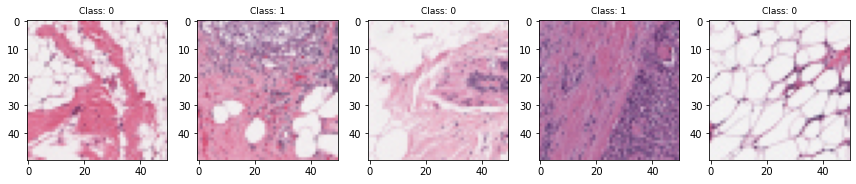

In [18]:

#visualize first few images
num_fig = 5

fig, axes = plt.subplots(1, num_fig, figsize=(12,12))

for i in range(5):
  axes[i].set_title('Class: ' + str(np.argmax(y[i])), fontsize=9 )
  axes[i].imshow(X[i])

plt.tight_layout()

## Split Data in Train, Validation and Test

In [0]:
train_split = 0.70
valid_split = 0.5

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=1-train_split, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=1-valid_split, random_state=42, shuffle=True)



In [20]:
#show the data counts
show_split(y_train, y_valid, y_test)

Total count: 277524

train count: 194266 (0.70000)
train cancer count: 55239 (0.28435)
train non-cancer count: 139027 (0.71565)

valid count: 41629 (0.15000)
valid cancer count: 11863 (0.28497)
valid non-cancer count: 29766 (0.71503)

test count: 41629 (0.15000)
test cancer count: 11684 (0.28067)
test non-cancer count: 29945 (0.71933)



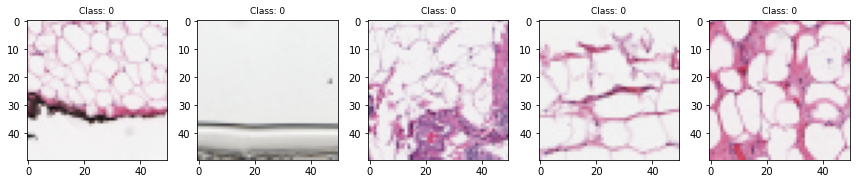

In [21]:
#visualize first few training images
num_fig = 5

fig, axes = plt.subplots(1, num_fig, figsize=(12,12))

for i in range(num_fig):
  axes[i].set_title('Class: ' + str(np.argmax(y_train[i])), fontsize=9 )
  axes[i].imshow(X_train[i])

plt.tight_layout()

# Balance the training

## Random Ovesampling
Reference: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


## Get all minority class images

In [0]:
X_minority = [X_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
y_minority = [y_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
num_maj = len([y for y in y_train if y[0] == 1])
num_min = len([y for y in y_train if y[0] == 0])

X_rdm, y_rdm = getNRandom(X_minority, y_minority, num_maj - num_min)

X_train_org = X_train.copy()
Y_train_org = y_train.copy()

X_train = X_train + X_rdm
y_train = np.insert(y_train, len(y_train), y_rdm, axis=0)

## Generate synthetic oversampling minority class

In [0]:
# blnGenerate = False

# shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'


# if blnGenerate:
#   X_org, X_nb, X_gen = getNSynthetic_Annoy(X_minority, num_maj - num_min)

#   pickle.dump( X_gen, open( shared_binary_fldr + 'X_gen_smote.p', "wb" ) )
#   pickle.dump( X_org, open( shared_binary_fldr + 'X_org_smote.p', "wb" ) )
#   pickle.dump( X_nb, open( shared_binary_fldr + 'X_nb_smote.p', "wb" ) )

# else:
#   X_org = pickle.load(open(binary_fldr + 'X_org_smote.p', 'rb'))
#   X_nb = pickle.load(open(binary_fldr + 'X_nb_smote.p', 'rb'))
#   X_gen = pickle.load(open(binary_fldr + 'X_gen_smote.p', 'rb'))
#   print('Load from binary') 

## Visualize synthetic image

In [0]:
# numImages = 10

# fig, axes = plt.subplots(numImages, 3, figsize=(12,20))

# idx_list = np.random.randint(0,len(X_gen),numImages)

# for i, idx in enumerate(idx_list):

#   axes[i][0].set_title('Original', fontsize=9 )
#   axes[i][0].imshow(X_org[idx])

#   axes[i][1].set_title('Neighbour', fontsize=9 )
#   axes[i][1].imshow(X_nb[idx])

#   axes[i][2].set_title('Generated', fontsize=9 )
#   axes[i][2].imshow(X_gen[idx])
  
# plt.tight_layout()

## Simple replication  
Take all the positive classes and generate additional images by flipping them horizontally and vertically


In [0]:
# #get the list of positive images
# pos_idx = [i for i in range(len(y_train)) if y_train[i][1] == 1]

# # make copies by fliping some top/bottom and some left/right
# for i in pos_idx:
#   x = X_train[i].copy()
  
#   if i % 2 == 0:
#     x = x.transpose(Image.FLIP_TOP_BOTTOM)
#   else :
#     x = x.transpose(Image.FLIP_LEFT_RIGHT)
  
  
#   X_train.append(x)
#   #y_train.append(y_train[i])
#   y_train = np.insert(y_train, len(y_train),  y_train[i], axis=0)

## Append and Save Training for re-use




In [0]:

# blnLoadTrainSmote = True

# shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'
  
# if blnLoadTrainSmote:
#   X_train = pickle.load(open(binary_fldr + 'X_train_smote.p', 'rb'))
#   y_train = pickle.load(open(binary_fldr + 'y_train_smote.p', 'rb'))
# else:
#   X_train = X_train + X_gen

#   for i in range(len(X_gen)):
#     y_train = np.insert(y_train, len(y_train), y_minority[0], axis=0)

#   pickle.dump( X_train, open( shared_binary_fldr + 'X_train_smote.p', "wb" ) )
#   pickle.dump( y_train, open( shared_binary_fldr + 'y_train_smote.p', "wb" ) )



In [0]:
# reshuffle the data
X_train, y_train = randomize(X_train, y_train)


In [28]:
#show the data counts
show_split(y_train, y_valid, y_test)

Total count: 361312

train count: 278054 (0.76957)
train cancer count: 139027 (0.50000)
train non-cancer count: 139027 (0.50000)

valid count: 41629 (0.11522)
valid cancer count: 11863 (0.28497)
valid non-cancer count: 29766 (0.71503)

test count: 41629 (0.11522)
test cancer count: 11684 (0.28067)
test non-cancer count: 29945 (0.71933)



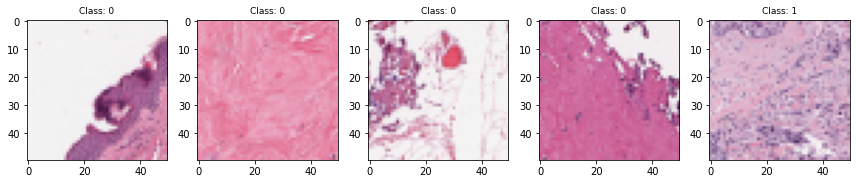

In [29]:
#visualize first few training images
num_fig = 5

fig, axes = plt.subplots(1, num_fig, figsize=(12,12))

for i in range(num_fig):
  axes[i].set_title('Class: ' + str(np.argmax(y_train[i])), fontsize=9 )
  axes[i].imshow(X_train[i])

plt.tight_layout()

# Set up image generators

## Setup Image Data Generator for Data augmentation

In [0]:
dataGen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             height_shift_range=0.2,
                             width_shift_range=0.2, 
                             shear_range=20,
                             fill_mode='reflect')

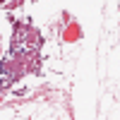

In [31]:
X_train[2].resize((120,120))

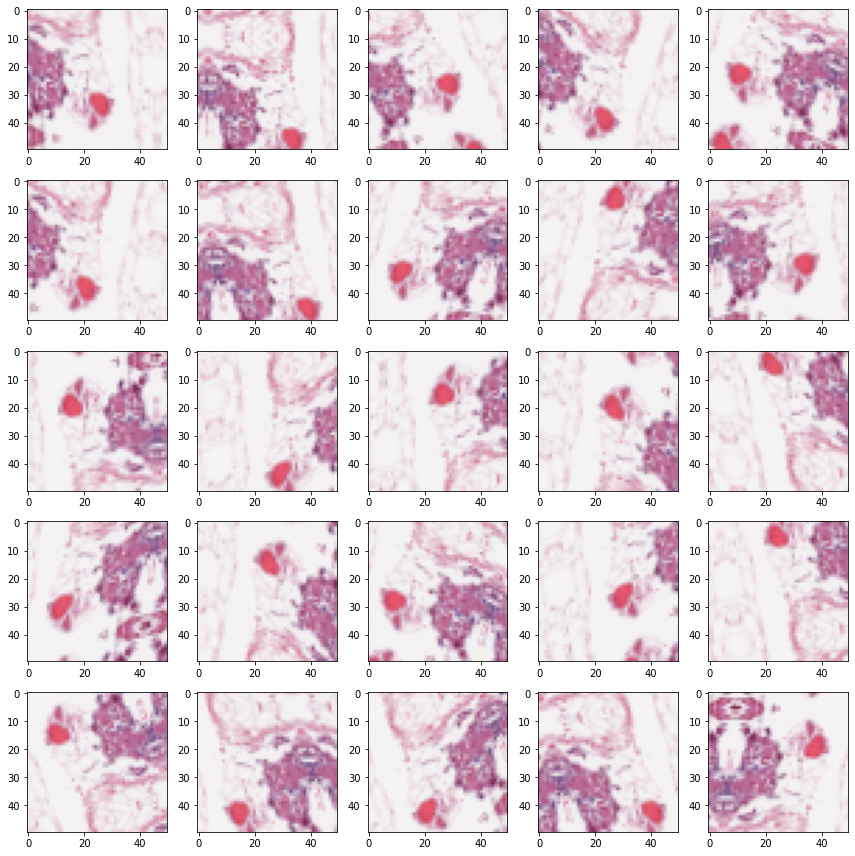

In [32]:
orig_rgb_img = pad(np.asarray(X_train[2]), (50,50,3), 255)

num_fig = 5

fig, axes = plt.subplots(num_fig, num_fig, figsize=(12,12))

for i in range(25):
  
  col = i % num_fig
  row = int(i / num_fig) 

  params = dataGen.get_random_transform(orig_rgb_img.shape)
  rgb_img = dataGen.apply_transform(orig_rgb_img, params)
  rgb_img = dataGen.standardize(rgb_img)

  axes[row][col].imshow(Image.fromarray(rgb_img.astype('uint8'), 'RGB'))



plt.tight_layout()




## Use custom image generator

In [0]:

batch_size = 512
scale_factor = 50/50
pad_flg = True
pad_size = (50,50,3)
pad_value = 255

train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value, dataGen)
valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

train_size = len(y_train)
valid_size = len(y_valid)
test_size = len(y_test)

train_steps = int(np.ceil(train_size/batch_size))
valid_steps = int(np.ceil(valid_size/batch_size))
test_steps = int(np.ceil(test_size/batch_size))


# Model


## Model 1 - Simple Architecuture

### Setup different architecture


Setting up simple Architecture 3 Convolution Layers with different number of filters.  The number of hidden units in the fully connected layers is equal to the number of filters


In [68]:
model_list = []

num_filters = [128]

for filters in num_filters:

  model = models.Sequential()
  model.add(layers.Conv2D(filters, (3,3), activation='relu', input_shape=(50,50,3),kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(filters, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

  model.summary()

  adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy', 'AUC'])
  
  model_list.append({'model':model, 'description': 'filters=' + str(filters)})

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0


### Training

Training with 25 epoch on each model

In [69]:
hist_list = []

for m in model_list:
  print('training model:{0}'.format(m['description']))
  hist =  m['model'].fit(x=train_image_label_generator, epochs=25,  steps_per_epoch = train_steps, 
                  validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)

  m['hist'] = hist



training model:filters=128
Epoch 1/25
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


544/544 [==============================] - 291s 534ms/step - loss: 0.7437 - accuracy: 0.7781 - auc: 0.8503 - val_loss: 0.6175 - val_accuracy: 0.8054 - val_auc: 0.8710
Epoch 2/25
544/544 [==============================] - 284s 522ms/step - loss: 0.5833 - accuracy: 0.8033 - auc: 0.8766 - val_loss: 0.5727 - val_accuracy: 0.8087 - val_auc: 0.8763
Epoch 3/25
544/544 [==============================] - 284s 521ms/step - loss: 0.5490 - accuracy: 0.8089 - auc: 0.8836 - val_loss: 0.5764 - val_accuracy: 0.7967 - val_auc: 0.8619
Epoch 4/25
544/544 [==============================] - 285s 524ms/step - loss: 0.5271 - accuracy: 0.8133 - auc: 0.8886 - val_loss: 0.5156 - val_accuracy: 0.8220 - val_auc: 0.8939
Epoch 5/25
544/544 [==============================] - 287s 528ms/step - loss: 0.5106 - accuracy: 0.8181 - auc: 0.8927 - val_loss: 0.5440 - val_accuracy: 0.8035 - val_auc: 0.8705
Epoch 6/25
544/544 [==============================] - 282s 518ms/step - loss: 0.4980 - accuracy: 0.8207 - auc: 0.8959 - v


### Evaluation

In [70]:

for m in model_list:

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Performance curves

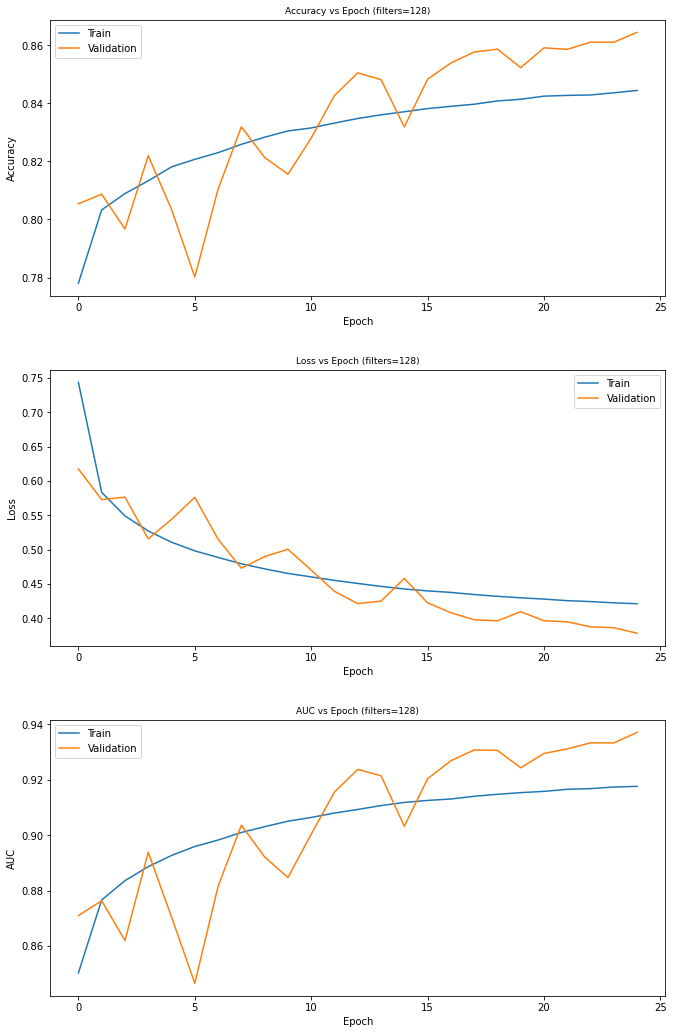

In [71]:
for m in model_list:
  plot_performance(m['hist'], m['description'])

### Confusion Matrix and Balanced Accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


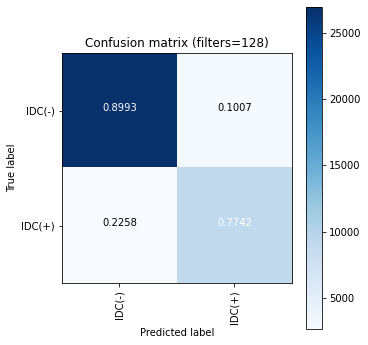

In [72]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in model_list:
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))


### Compare Models orderd by BAC

In [73]:
# Comparison of all models

modelName = [m['description'] for m in model_list ]
modelBAC = [m['balanced_acc'] for m in model_list ]
modelLoss = [m['score'][0] for m in model_list ]
modelAccuracy = [m['score'][1] for m in model_list ]
modelAUC = [m['score'][2] for m in model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

,model,bac,accuracy,loss
0,filters=128,0.836768,0.864205,0.379308


Increasing the number of trainable parameters did not significanty import the accuracy of the model

## Model 2 - Iconic Architectures - Top Layer



### Setup and training

In [74]:
tf_model_list = []

input_shape = (50, 50, 3)

modelResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
modelVGG16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


baseModels = [
              {'name':'ResNet50', 'model':modelResNet50, 'input_shape':input_shape},
              {'name':'VGG16', 'model':modelVGG16, 'input_shape':input_shape},
              {'name':'DenseNet121', 'model':modelDenseNet121, 'input_shape':input_shape}
              ] 

for baseModel in baseModels:
  print('base:' + baseModel['name'])
    
  model = Sequential([baseModel['model'],  
                      layers.Flatten(),
                      layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
                      
                      ])

  #only train last layer
  for layer in model.layers[:-5]:
    layer.trainable = False

  #optimizer
  #sgd = optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
  adam = optimizers.Adam(learning_rate=1e-5, amsgrad=True)

  # Compile the model
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=["accuracy", "AUC"])
  model.summary()


  #train model
  hist =  model.fit(x=train_image_label_generator, epochs=25,  steps_per_epoch = train_steps, 
                  validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)
  
  #store the model and history
  tf_model_list.append({'model':model, 'description': baseModel['name'], 'hist':hist})


  

  

29089792/29084464 [==============================] - 1s 0us/step
base:ResNet50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 16386     
Total params: 23,604,098
Trainable params: 23,550,978
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/25
544/544 [==============================] - 299s 549ms/step - loss: 0.5361 - accuracy: 0.7853 - auc: 0.8548 - val_loss: 35.9913 - val_accuracy: 0.7119 - val_auc: 0.7124
Epoch 2/25
544/544 [==============================] - 297s 545ms/step - loss: 0.3868 - accuracy: 0.8363 - auc: 0.9106 - val_loss: 0.7775 - val_accuracy: 0.6526 - val_auc: 0.7096
Epoch 3/25
544/544 [==============================] - 298s 548ms/step - loss: 0.3619 - accuracy: 0.8477 - auc: 0.9216 - val_loss: 0.3626 - val_accuracy: 0.8515 - val_auc: 0.9226
Epoch 4/25
544/544 [==============================] - 295s 542ms/step - loss: 0.3478 - accuracy: 0.8538 - auc: 0.9276 - val_loss: 0.3327 - val_accuracy: 0.8617 - val_auc: 0.9337
Epoch 5/25
544/544 [==============================] - 296s 545ms/step - loss: 0.3379 - accuracy: 0.8581 - auc: 0.9317 - val_loss: 0.3249 - val_accuracy: 0.8648 - val_auc: 0.9369
Epoch 6/25
544/544 [==============================] - 295s 543ms/step - loss: 0.3302 - accuracy: 0.8618 - auc

### Evaulation


In [75]:
for m in tf_model_list:

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Performance curves


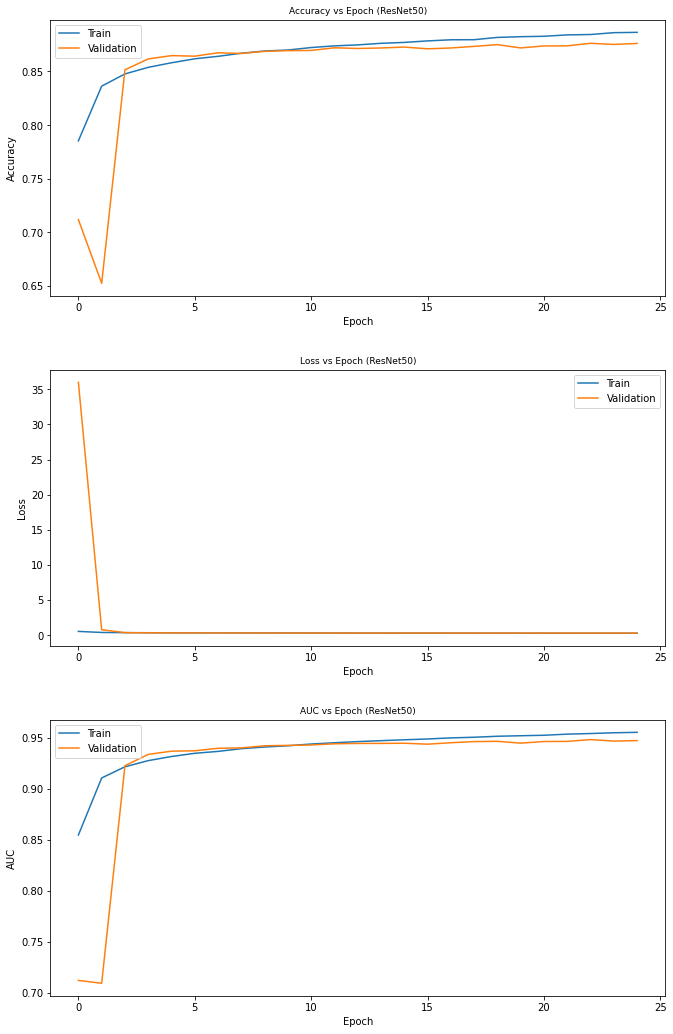

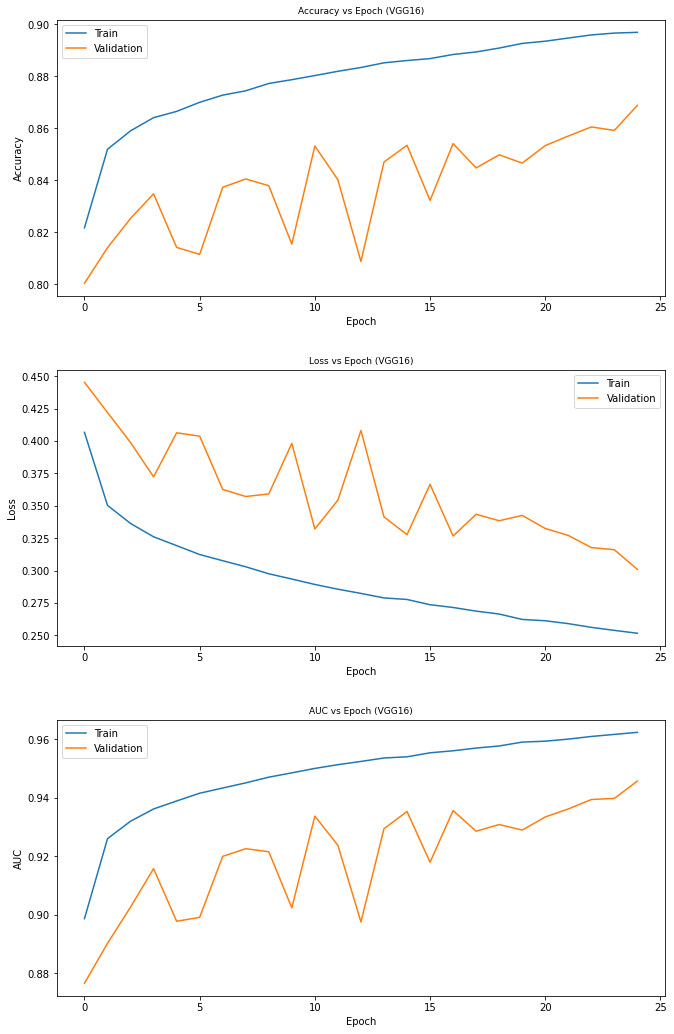

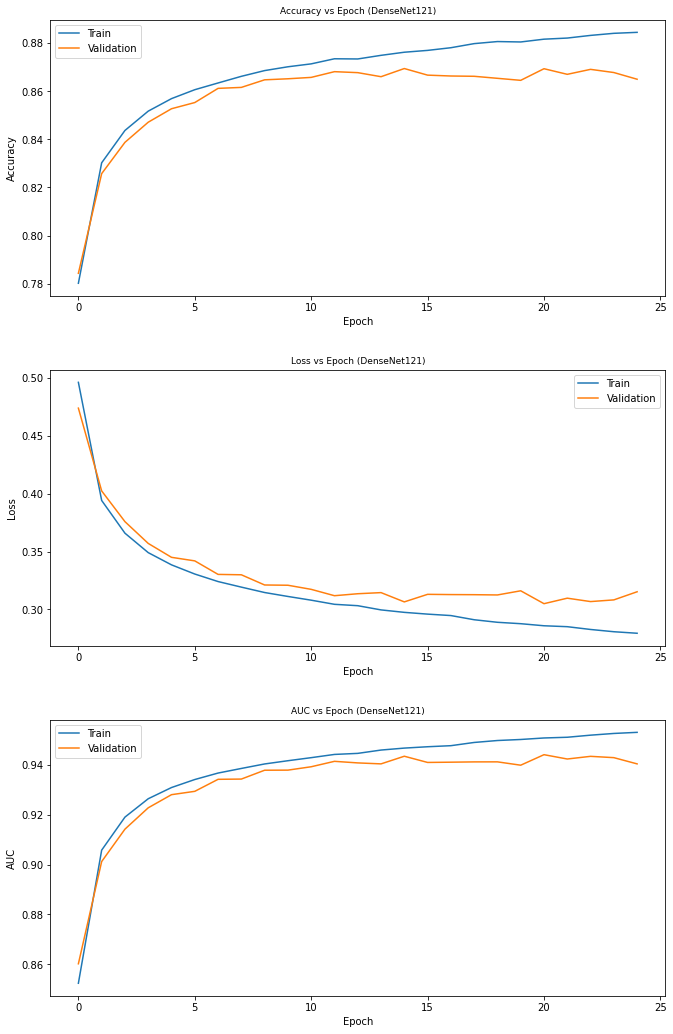

In [76]:
for m in tf_model_list:
  plot_performance(m['hist'], m['description'])

### Confusion Matrix


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


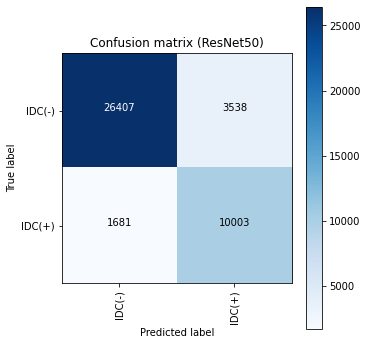

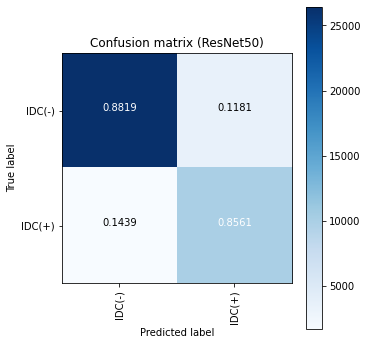

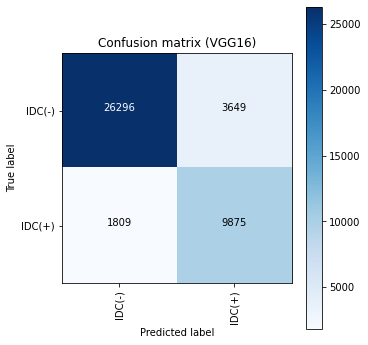

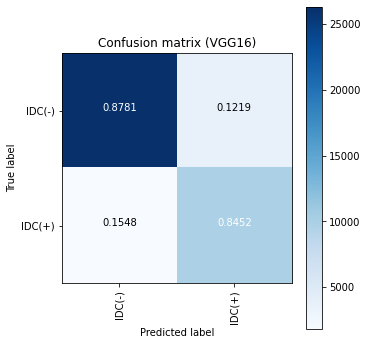

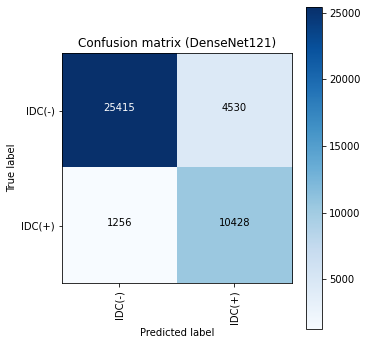

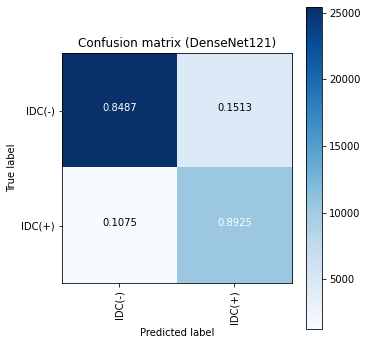

In [77]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=True)


### Compare Models order by BAC

In [78]:
modelName = [m['description'] for m in tf_model_list ]
modelBAC = [m['balanced_acc'] for m in tf_model_list ]
modelLoss = [m['score'][0] for m in tf_model_list ]
modelAccuracy = [m['score'][1] for m in tf_model_list ]
modelAUC = [m['score'][2] for m in tf_model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

,model,bac,accuracy,loss
2,DenseNet121,0.870613,0.861010,0.323179
0,ResNet50,0.868989,0.874631,0.305752
1,VGG16,0.861658,0.868889,0.305473


## Model 3 - Iconic Architure - All trainable layers

### Setup and training

In [34]:
tf_model_list = []

input_shape = (50, 50, 3)

modelResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
modelVGG16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


baseModels = [
              {'name':'ResNet50', 'model':modelResNet50, 'input_shape':input_shape},
              {'name':'VGG16', 'model':modelVGG16, 'input_shape':input_shape},
              {'name':'DenseNet121', 'model':modelDenseNet121, 'input_shape':input_shape},
              ] 

for baseModel in baseModels:
  print('base:' + baseModel['name'])
    
  model = Sequential([baseModel['model'],  layers.Flatten(),
                    layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))])

  # #only train last layer
  # for layer in model.layers[:-1]:
  #   layer.trainable = False

  #optimizer
  #sgd = optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
  adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)

  # Compile the model
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=["accuracy", "AUC"])
  model.summary()


  #train model
  hist =  model.fit(x=train_image_label_generator, epochs=25,  steps_per_epoch = train_steps, 
                  validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)
  
  #store the model and history
  tf_model_list.append({'model':model, 'description': baseModel['name'], 'hist':hist})


  

  

29089792/29084464 [==============================] - 1s 0us/step
base:ResNet50
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 23,604,098
Trainable params: 23,550,978
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/25
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


544/544 [==============================] - 342s 628ms/step - loss: 0.3833 - accuracy: 0.8445 - auc: 0.9167 - val_loss: 1.0633 - val_accuracy: 0.3268 - val_auc: 0.2646
Epoch 2/25
544/544 [==============================] - 336s 618ms/step - loss: 0.3188 - accuracy: 0.8683 - auc: 0.9397 - val_loss: 0.6972 - val_accuracy: 0.6313 - val_auc: 0.7094
Epoch 3/25
544/544 [==============================] - 339s 624ms/step - loss: 0.3034 - accuracy: 0.8760 - auc: 0.9458 - val_loss: 0.3014 - val_accuracy: 0.8743 - val_auc: 0.9464
Epoch 4/25
544/544 [==============================] - 342s 629ms/step - loss: 0.2883 - accuracy: 0.8809 - auc: 0.9505 - val_loss: 0.2986 - val_accuracy: 0.8753 - val_auc: 0.9476
Epoch 5/25
544/544 [==============================] - 339s 623ms/step - loss: 0.2778 - accuracy: 0.8852 - auc: 0.9540 - val_loss: 0.3016 - val_accuracy: 0.8741 - val_auc: 0.9476
Epoch 6/25
544/544 [==============================] - 341s 626ms/step - loss: 0.2682 - accuracy: 0.8889 - auc: 0.9571 - v

### Evaulation


In [35]:
for m in tf_model_list:

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Performance curves


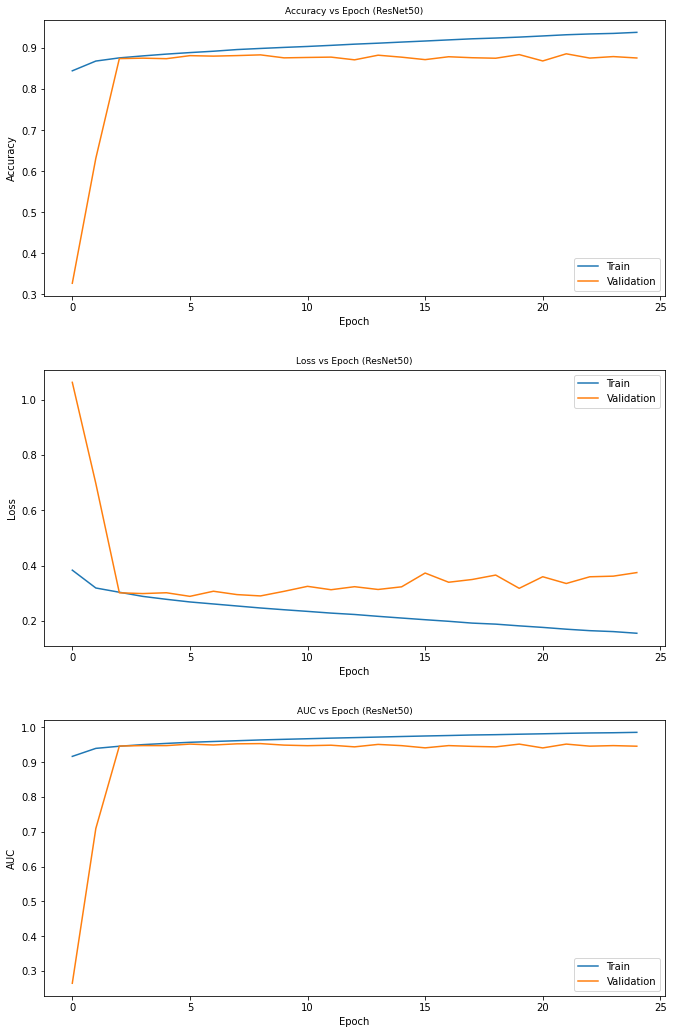

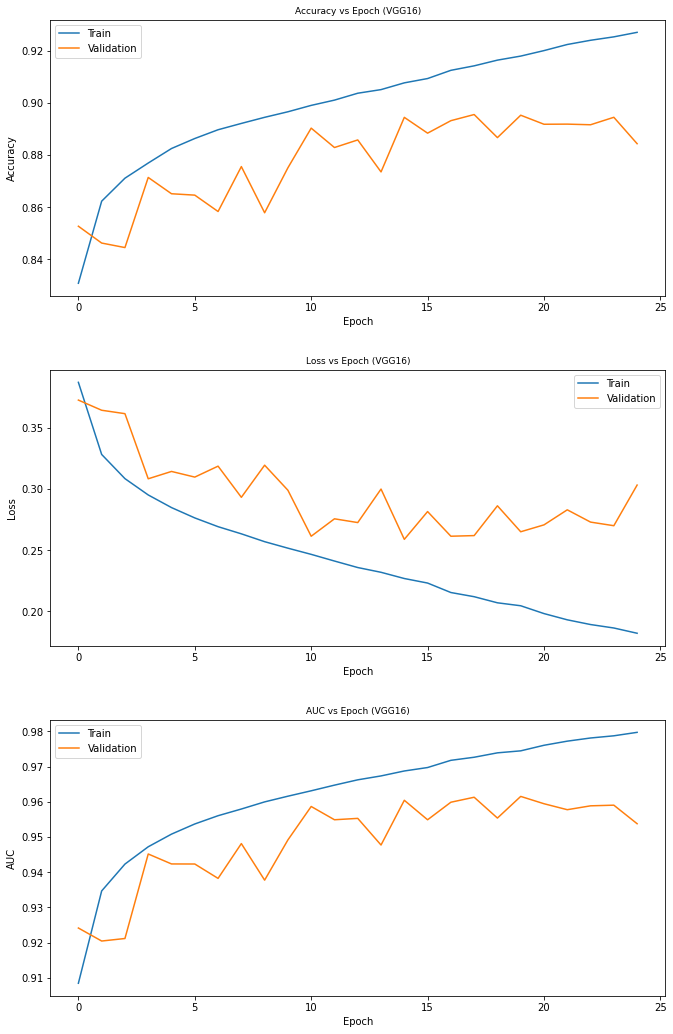

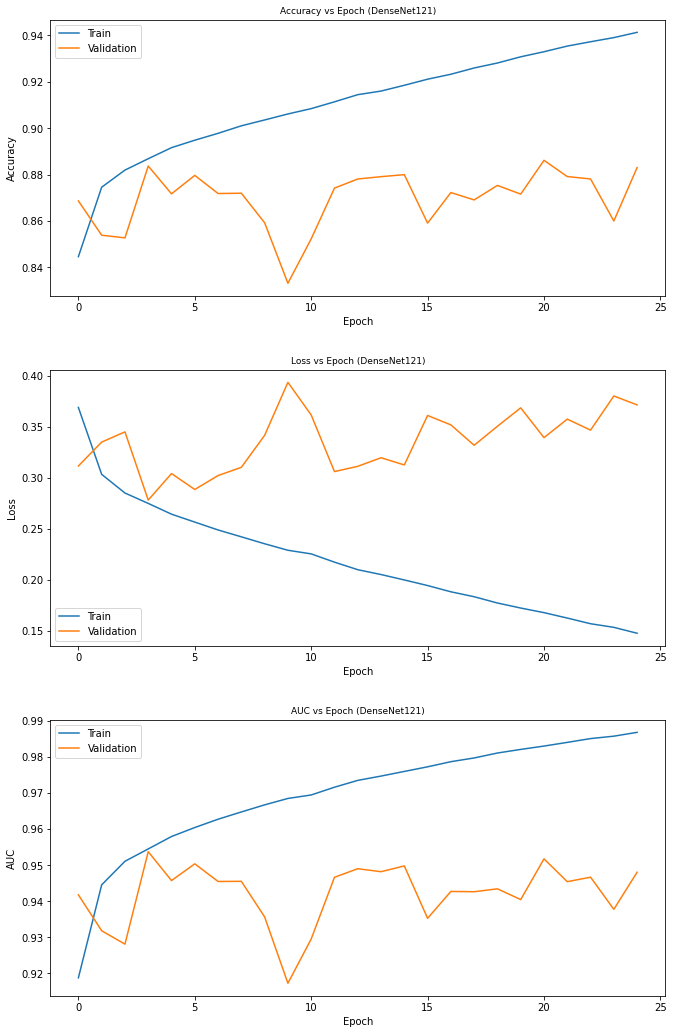

In [36]:
for m in tf_model_list:
  plot_performance(m['hist'], m['description'])

### Confusion Matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


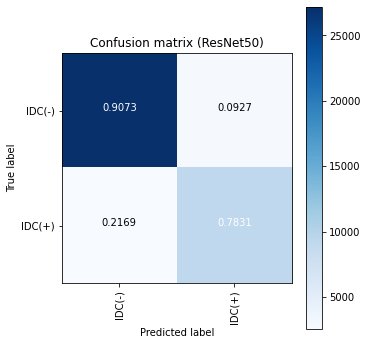

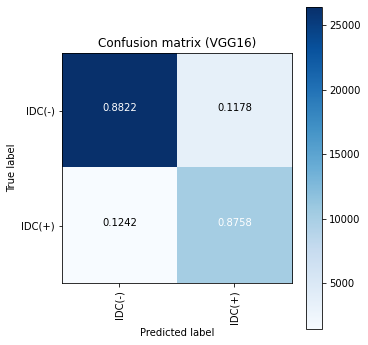

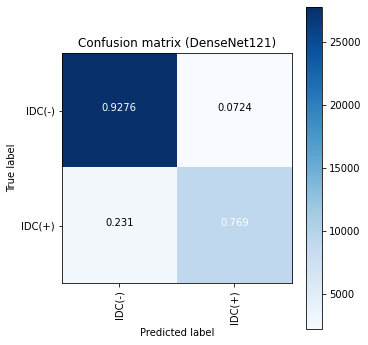

In [37]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))



### Compare Models order by BAC

In [38]:
modelName = [m['description'] for m in tf_model_list ]
modelBAC = [m['balanced_acc'] for m in tf_model_list ]
modelLoss = [m['score'][0] for m in tf_model_list ]
modelAccuracy = [m['score'][1] for m in tf_model_list ]
modelAUC = [m['score'][2] for m in tf_model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

,model,bac,accuracy,loss
1,VGG16,0.878999,0.880396,0.314737
2,DenseNet121,0.848317,0.883110,0.371582
0,ResNet50,0.845193,0.872421,0.389811


## Model 3b - Iconic Architure - All trainable layers

### Setup and training

In [0]:
tf_model_list = []

input_shape = (50, 50, 3)

# modelResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
# modelVGG16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


baseModels = [
              # {'name':'ResNet50', 'model':modelResNet50, 'input_shape':input_shape},
              #{'name':'VGG16', 'model':modelVGG16, 'input_shape':input_shape},
               {'name':'DenseNet121', 'model':modelDenseNet121, 'input_shape':input_shape},
              ] 

for baseModel in baseModels:
  print('base:' + baseModel['name'])
    
  model = Sequential([baseModel['model'],  layers.Flatten(),
                    layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))])

  # #only train last layer
  # for layer in model.layers[:-1]:
  #   layer.trainable = False

  #optimizer
  #sgd = optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
  adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)

  # Compile the model
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=["accuracy", "AUC"])
  model.summary()


  #train model
  hist =  model.fit(x=train_image_label_generator, epochs=25,  steps_per_epoch = train_steps, 
                  validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)
  
  #store the model and history
  tf_model_list.append({'model':model, 'description': baseModel['name'], 'hist':hist})


  

  

base:DenseNet121
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


621/621 [==============================] - 240s 387ms/step - loss: 0.3095 - accuracy: 0.8704 - auc: 0.9429 - val_loss: 0.4056 - val_accuracy: 0.8474 - val_auc: 0.9296
Epoch 2/25
621/621 [==============================] - 239s 385ms/step - loss: 0.2433 - accuracy: 0.8999 - auc: 0.9645 - val_loss: 0.2964 - val_accuracy: 0.8791 - val_auc: 0.9509
Epoch 3/25
621/621 [==============================] - 239s 385ms/step - loss: 0.2247 - accuracy: 0.9076 - auc: 0.9697 - val_loss: 0.2771 - val_accuracy: 0.8849 - val_auc: 0.9560
Epoch 4/25
621/621 [==============================] - 239s 385ms/step - loss: 0.2141 - accuracy: 0.9123 - auc: 0.9725 - val_loss: 0.2849 - val_accuracy: 0.8815 - val_auc: 0.9520
Epoch 5/25
621/621 [==============================] - 240s 387ms/step - loss: 0.2044 - accuracy: 0.9162 - auc: 0.9749 - val_loss: 0.2759 - val_accuracy: 0.8844 - val_auc: 0.9547
Epoch 6/25
621/621 [==============================] - 239s 386ms/step - loss: 0.1978 - accuracy: 0.9187 - auc: 0.9765 - v

### Evaulation


In [0]:
for m in tf_model_list:

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Performance curves


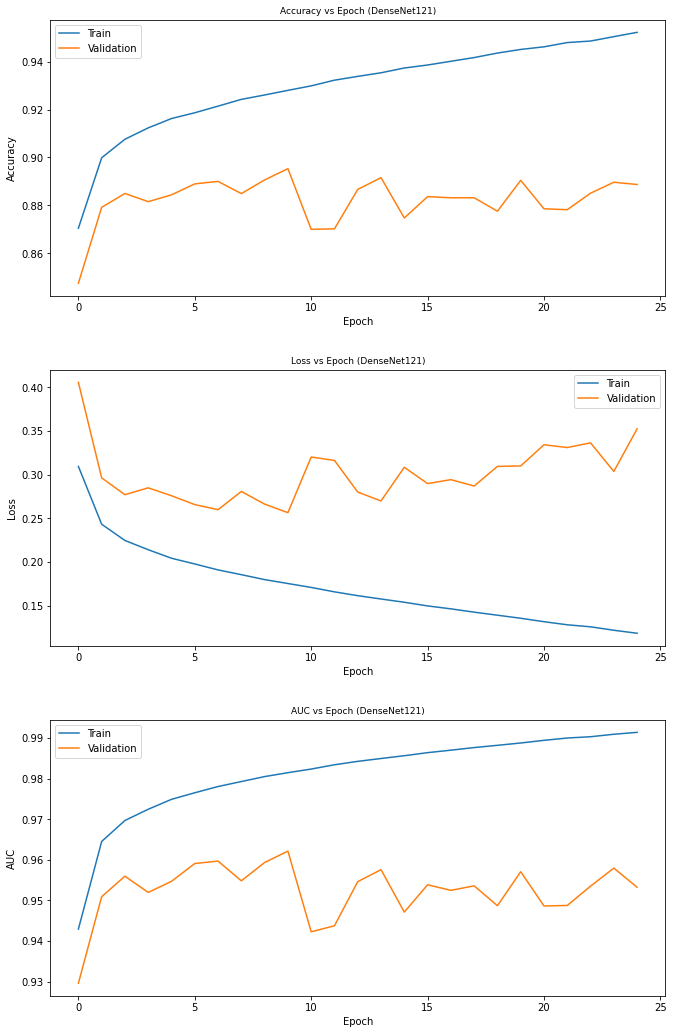

In [0]:
for m in tf_model_list:
  plot_performance(m['hist'], m['description'])

### Confusion Matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


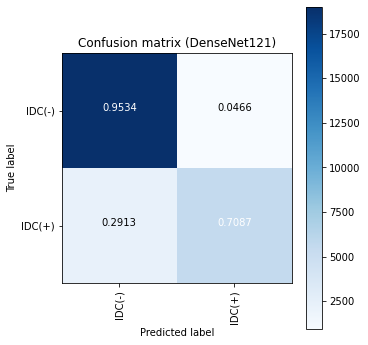

In [0]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))



### Compare Models order by BAC

In [0]:
modelName = [m['description'] for m in tf_model_list ]
modelBAC = [m['balanced_acc'] for m in tf_model_list ]
modelLoss = [m['score'][0] for m in tf_model_list ]
modelAccuracy = [m['score'][1] for m in tf_model_list ]
modelAUC = [m['score'][2] for m in tf_model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

,model,bac,accuracy,loss
0,DenseNet121,0.831041,0.884337,0.364614


# Cross Validation
reference: https://machinelearningmastery.com/k-fold-cross-validation/

Cross validation is used to estimate the perfomance of a model on unseen data to give confidence that a final model trained on ALL data will be valid.

All models trained in cross validation are discarded.  Only the evaluation score is retained for summary

## Setup stratifed K-Folds
reference: https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/



In [0]:
#model 1
def simple_seq_model(numFilters): 
  model = models.Sequential()
  model.add(layers.Conv2D(numFilters, (3,3), activation='relu', input_shape=(50,50,3),kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(numFilters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(numFilters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(numFilters, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

  model.summary()

  adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy', 'AUC'])

  return model


In [0]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)


In [0]:
simple_seq_model(128)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 128)       3584      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

## Execute Cross Validation

In [0]:
132492 - 52524

79968

In [0]:
batch_size = 512
scale_factor = 50/50
pad_flg = True
pad_size = (50,50,3)
pad_value = 255

num_epoch = 25


fold_idx = 0
fold_model_list = []


# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X, y_label):
  X_train = [X[i] for i in train_ix ]
  X_valid_test = [X[i] for i in test_ix ]
  
  y_train = [y[i] for i in train_ix ]
  y_valid_test = [y[i] for i in test_ix ]
  
  X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=1-valid_split, random_state=42, shuffle=True)

  print('fold {0}'.format(fold_idx)) 
  print ('num train: {0} ({1})  num test:{2} ({3})'.format(len(X_train), len(X_train)/len(X),len(X_test),len(X_test)/len(X)))
  
  #balance the training set 

  # ## get the list of positive images
  # pos_idx = [i for i in range(len(y_train)) if y_train[i][1] == 1]

  # ## make copies by fliping some top/bottom and some left/right
  # for i in pos_idx:
  #   x = X_train[i].copy()
    
  #   if i % 2 == 0:
  #     x = x.transpose(Image.FLIP_TOP_BOTTOM)
  #   else :
  #     x = x.transpose(Image.FLIP_LEFT_RIGHT)
    
    
  #   X_train.append(x)
  #   y_train = np.insert(y_train, len(y_train),  y_train[i], axis=0)

  #show split
  show_split(y_train, y_valid, y_test)
  
  # #set up generators
  # train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  # valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  # test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  # train_size = len(y_train)
  # valid_size = len(y_valid)
  # test_size = len(y_test)

  # train_steps = int(np.ceil(train_size/batch_size))
  # valid_steps = int(np.ceil(valid_size/batch_size))
  # test_steps = int(np.ceil(test_size/batch_size))
  

  # # simple model
  # mdl = simple_seq_model(128)

  # #train
  # hist =  mdl.fit(x=train_image_label_generator, epochs=num_epoch,  steps_per_epoch = train_steps, 
  #                 validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)


  # fold_model_list.append({"model": mdl, 'description': 'fold={0}'.format(fold_idx), 'hist': hist, 'X_test':X_test, 'y_test':y_test})
  
  # # #TO DO -- Plot performance
  # # plot_performance(hist, 'fold# {0}  filters={1}'.format(fold_idx, 128))

  # # #evaluate
  # # scores =  mdl.evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  
  # # cross_scores.append(scores)
  print()
  fold_idx += 1

  


fold 0
num train: 185016 (0.6666666666666666)  num test:46254 (0.16666666666666666)
Total count: 277524

train count: 185016 (0.66667)
train cancer count: 52524 (0.28389)
train non-cancer count: 132492 (0.71611)

valid count: 46254 (0.16667)
valid cancer count: 12961 (0.28021)
valid non-cancer count: 33293 (0.71979)

test count: 46254 (0.16667)
test cancer count: 13301 (0.28756)
test non-cancer count: 32953 (0.71244)


fold 1
num train: 185016 (0.6666666666666666)  num test:46254 (0.16666666666666666)
Total count: 277524

train count: 185016 (0.66667)
train cancer count: 52524 (0.28389)
train non-cancer count: 132492 (0.71611)

valid count: 46254 (0.16667)
valid cancer count: 13131 (0.28389)
valid non-cancer count: 33123 (0.71611)

test count: 46254 (0.16667)
test cancer count: 13131 (0.28389)
test non-cancer count: 33123 (0.71611)


fold 2
num train: 185016 (0.6666666666666666)  num test:46254 (0.16666666666666666)
Total count: 277524

train count: 185016 (0.66667)
train cancer count:

## Evaulation


In [0]:
for m in fold_model_list:

  X_test = m['X_test']
  y_test = m['y_test']

  test_size = len(y_test)
  test_steps = int(np.ceil(test_size/batch_size))

  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  
  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## Performance curves


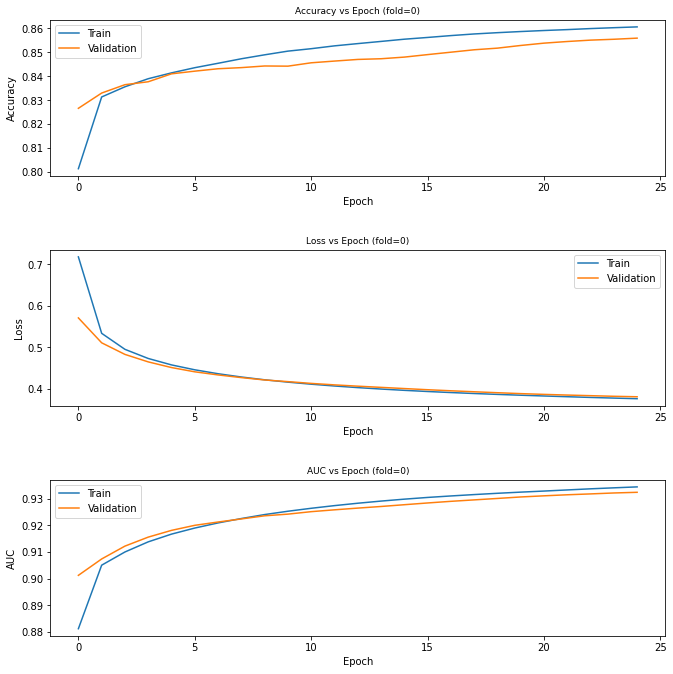

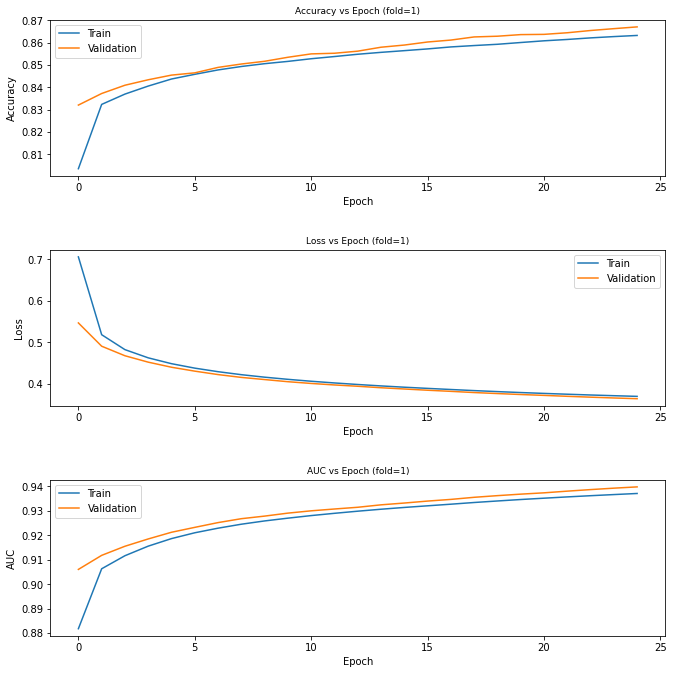

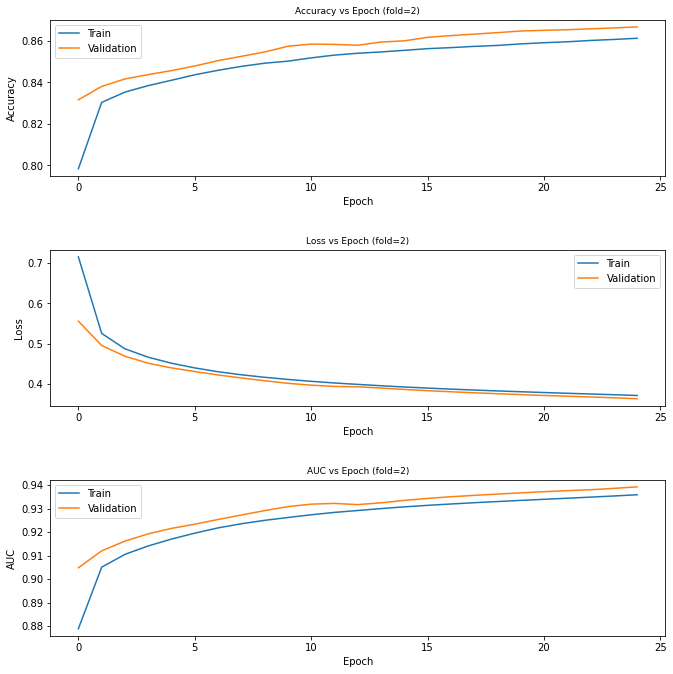

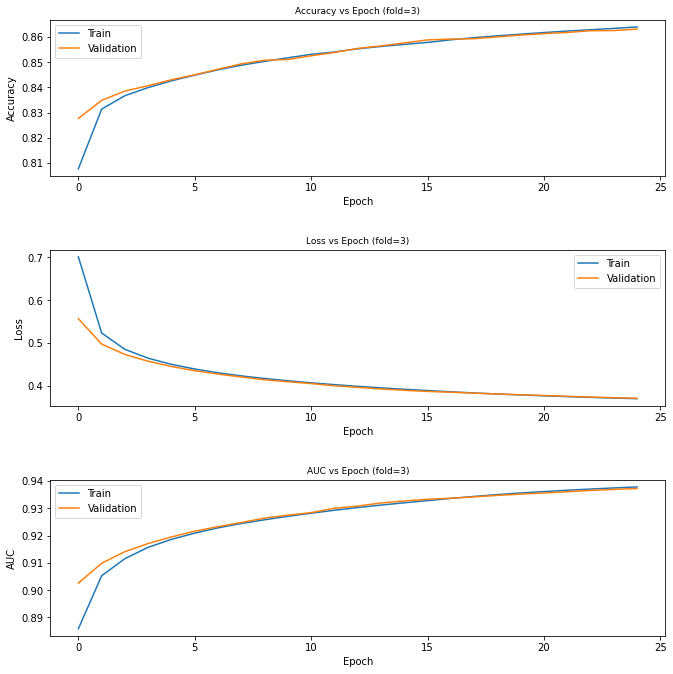

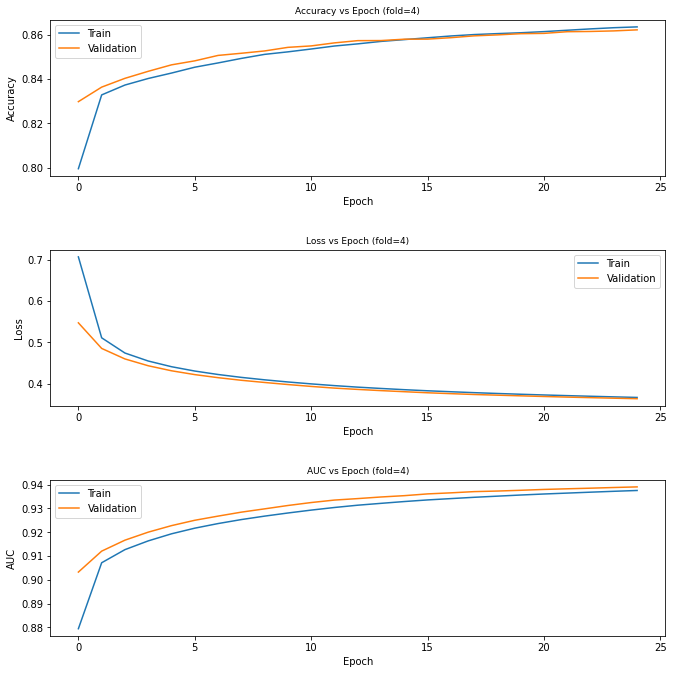

In [0]:
for m in fold_model_list:
  plot_performance(m['hist'], m['description'])

## Confusion Matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


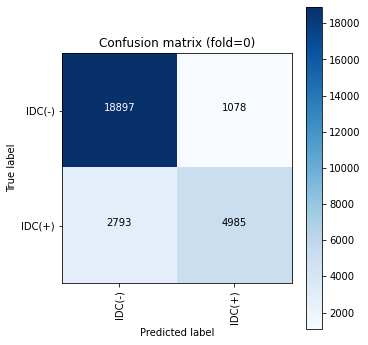

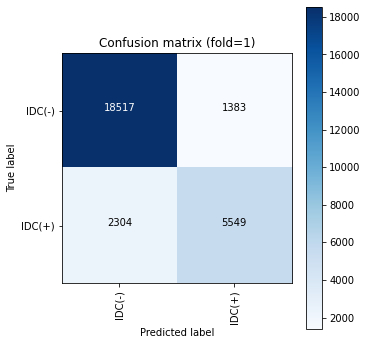

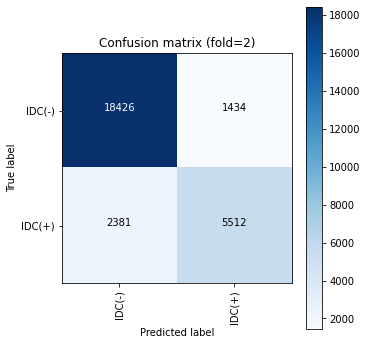

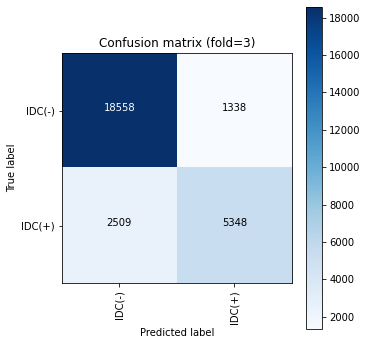

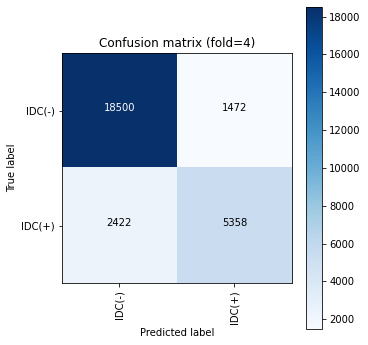

In [0]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in fold_model_list:
  X_test = m['X_test']
  y_test = m['y_test']

  test_size = len(y_test)
  test_steps = int(np.ceil(test_size/batch_size))

  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))



## Compare Folds order by BAC, Accuracy, Loss

In [0]:
modelName = [m['description'] for m in fold_model_list ]
modelBAC = [m['balanced_acc'] for m in fold_model_list ]
modelLoss = [m['score'][0] for m in fold_model_list ]
modelAccuracy = [m['score'][1] for m in fold_model_list ]
modelAUC = [m['score'][2] for m in fold_model_list ]


df = pd.DataFrame({'model':modelName, 'bac':modelBAC, 'accuracy':modelAccuracy, 'loss':modelLoss })
df = df.sort_values('bac', ascending=False)

df

,model,bac,accuracy,loss
1,fold=1,0.818556,0.867149,0.360254
2,fold=2,0.813067,0.862537,0.369524
4,fold=4,0.807493,0.859686,0.371599
3,fold=3,0.806709,0.861384,0.371456
0,fold=0,0.793471,0.860520,0.373842


{'boxes': [<matplotlib.lines.Line2D at 0x7fd6b8383240>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd8702aca58>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd8702ac5f8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd8702acdd8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd8733abe10>,
  <matplotlib.lines.Line2D at 0x7fd8733ab6a0>]}

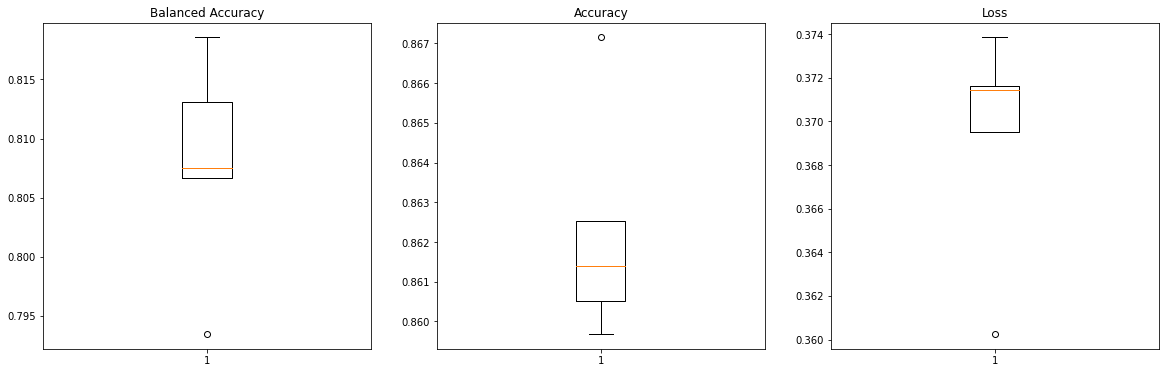

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
axes[0].set_title('Balanced Accuracy')
axes[0].boxplot(df.bac)

axes[1].set_title('Accuracy')
axes[1].boxplot(df.accuracy)

axes[2].set_title('Loss')
axes[2].boxplot(df.loss)


In [0]:
df.mean()

bac         0.807859
accuracy    0.862255
loss        0.369335
dtype: float64